In [1]:
%cd ../

/mnt/kireev/pycharm-deploy/vtb


In [2]:
import pickle
import random

In [3]:
from glob import glob

In [4]:
import numpy as np
import pandas as pd

In [5]:
import torch
import pytorch_lightning as pl

In [6]:
from pyhocon import ConfigFactory

In [7]:
import matplotlib.pyplot as plt

In [8]:
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load import augmentation_chain
from dltranz.data_load.augmentations.seq_len_limit import SeqLenLimit
from dltranz.data_load.augmentations.random_slice import RandomSlice

from dltranz.seq_encoder import create_encoder

from dltranz.metric_learn.sampling_strategies import get_sampling_strategy
from dltranz.metric_learn.losses import get_loss

from dltranz.tb_interface import get_scalars

In [9]:
from vtb_code.data import PairedDataset, paired_collate_fn, PairedZeroDataset, DropDuplicate
from vtb_code.metrics import PrecisionK, MeanReciprocalRankK, ValidationCallback

In [10]:
FOLD_ID = 4

In [11]:
fold_id_test = FOLD_ID

In [12]:
folds_count = len(glob('data/train_matching_*.csv'))
folds_count

6

In [13]:
# fold_id_valid = np.random.choice([i for i in range(folds_count) if i != fold_id_test], size=1)[0]
fold_id_valid = (fold_id_test + 1) % folds_count
fold_id_valid

5

In [14]:
df_matching_train = pd.concat([pd.read_csv(f'data/train_matching_{i}.csv')
                              for i in range(folds_count) 
                              if i not in (fold_id_test, fold_id_valid)])
df_matching_valid = pd.read_csv(f'data/train_matching_{fold_id_valid}.csv')
df_matching_test = pd.read_csv(f'data/train_matching_{fold_id_test}.csv')

In [15]:
[len(df) for df in [df_matching_train, df_matching_valid, df_matching_test]]

[11721, 2930, 2930]

In [16]:
%%time
with open(f'data/features_f{FOLD_ID}.pickle', 'rb') as f:
    (
        features_trx_train,
        features_trx_valid,
        features_trx_test,
        features_trx_puzzle,
        features_click_train,
        features_click_valid,
        features_click_test,
        features_click_puzzle,
    ) = pickle.load(f)

CPU times: user 12.2 s, sys: 4.37 s, total: 16.5 s
Wall time: 16.6 s


In [17]:
from dltranz.seq_encoder.utils import NormEncoder

In [18]:
class L2Scorer(torch.nn.Module):
    def forward(self, x):
        B, H = x.size()
        a, b =x[:, :H // 2], x[:, H // 2:]
        return -(a - b).pow(2).sum(dim=1)

In [19]:
class CustomTrxTransform(torch.nn.Module):
    def forward(self, x):
#         x.payload['mcc_code'] = torch.clamp(x.payload['mcc_code'], 0, 300)
#         x.payload['c_cnt_clamp'] = torch.clamp(x.payload['c_cnt'], 0, 20).int()
        return x
    
class CustomClickTransform(torch.nn.Module):
    def forward(self, x):
#         x.payload['cat_id'] = torch.clamp(x.payload['cat_id'], 0, 300)
#         x.payload['level_0'] = torch.clamp(x.payload['level_0'], 0, 200)
#         x.payload['level_1'] = torch.clamp(x.payload['level_1'], 0, 200)
#         x.payload['level_2'] = torch.clamp(x.payload['level_2'], 0, 200)
#         x.payload['c_cnt_clamp'] = torch.clamp(x.payload['c_cnt'], 0, 20).int()
        return x

In [20]:
class DateFeaturesTransform(torch.nn.Module):
    def forward(self, x):
        et = x.payload['event_time'].int()
        et_day = et.div(24 * 60 * 60, rounding_mode='floor').int()
        x.payload['hour'] = et.div(60 * 60, rounding_mode='floor') % 24 + 1
#         x.payload['weekday'] = et.div(60 * 60 * 24, rounding_mode='floor') % 7 + 1
#         x.payload['hour_s'] = torch.sin(2 * np.pi * (et % (60 * 60 * 24)) / (60 * 60 * 24))
#         x.payload['hour_c'] = torch.cos(2 * np.pi * (et % (60 * 60 * 24)) / (60 * 60 * 24))
#         x.payload['day_diff'] = torch.clamp(torch.diff(et_day, prepend=et_day[:, :1], dim=1), 0, 14)
#         x.payload['day_diff_c'] = torch.clamp(torch.diff(et, prepend=et[:, :1], dim=1) / (60 * 60 * 24), 0, 14)
        return x

In [21]:
from dltranz.trx_encoder import TrxEncoder, PaddedBatch
from dltranz.seq_encoder.rnn_encoder import RnnEncoder
from dltranz.seq_encoder.utils import LastStepEncoder

In [22]:
class PBLinear(torch.nn.Linear):
    def forward(self, x: PaddedBatch):
        return PaddedBatch(super().forward(x.payload), x.seq_lens)

In [23]:
class PairedModule(pl.LightningModule):
    def __init__(self, params, sampling_strategy_params, loss_params, k,
                 lr, weight_decay,
                 step_size, gamma,
                 base_lr, max_lr, step_size_up, step_size_down,
                ):
        super().__init__()
        self.save_hyperparameters()
        
        t = TrxEncoder(params['trx_seq.trx_encoder'])
        print(t.output_size)
        self.rnn_enc =  torch.nn.Sequential(
            RnnEncoder(params['common_trx_size'], params['rnn']), 
            LastStepEncoder(),
            NormEncoder(),
        )
        self.seq_encoder_trx_size = params['rnn.hidden_size']
        self._seq_encoder_trx = torch.nn.Sequential(
            CustomTrxTransform(),
            DateFeaturesTransform(),
            t, PBLinear(t.output_size, params['common_trx_size']),
        )
        t = TrxEncoder(params['click_seq.trx_encoder'])
        print(t.output_size)
        self._seq_encoder_click = torch.nn.Sequential(
            CustomClickTransform(),
            DateFeaturesTransform(),
            t, PBLinear(t.output_size, params['common_trx_size']),
        )
        
        self.cls = torch.nn.Sequential(
            L2Scorer(),
        )

        sampling_strategy = get_sampling_strategy(sampling_strategy_params)
        self.loss_fn = get_loss(loss_params, sampling_strategy)
        
        self.train_precision = PrecisionK(k=k, compute_on_step=False)
        self.train_mrr = MeanReciprocalRankK(k=k, compute_on_step=False)
        self.valid_precision = PrecisionK(k=k, compute_on_step=False)
        self.valid_mrr = MeanReciprocalRankK(k=k, compute_on_step=False)
        
    def seq_encoder_trx(self, x):
        x = self._seq_encoder_trx(x)
        return self.rnn_enc(x)
    
    def seq_encoder_click(self, x):
        x = self._seq_encoder_click(x)
        return self.rnn_enc(x)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        if self.hparams.step_size is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optim, step_size=self.hparams.step_size, gamma=self.hparams.gamma)
        else:
            sheduler = torch.optim.lr_scheduler.CyclicLR(
                optim,
                base_lr=self.hparams.base_lr, max_lr=self.hparams.max_lr,
                step_size_up=self.hparams.step_size_up,
                step_size_down=self.hparams.step_size_down,
                cycle_momentum=False,
            )
            scheduler = {'scheduler': sheduler, 'interval': 'step'}
        return [optim], [scheduler]
    
#     def forward(self, batch):
#         return logits
            
    def training_step(self, batch, batch_idx):
        x_trx, l_trx, m_trx, x_click, l_click, m_click = batch
        
        self.log('seq_le/trx_mean', x_trx.seq_lens.float().mean())
        self.log('seq_len/click_mean', x_click.seq_lens.float().mean())
        
        z_trx = self.seq_encoder_trx(x_trx)  # B, H
        z_click = self.seq_encoder_click(x_click)  # B, H
        
        B = z_trx.size(0)
        device = z_trx.device
        
        loss = self.loss_fn(
            torch.cat([z_trx, z_click], dim=0),
            torch.cat([l_trx, l_click], dim=0),
        )
        self.log('loss/loss_ml', loss, prog_bar=True)
        
        with torch.no_grad():
            out = -(z_trx.unsqueeze(1) - z_click.unsqueeze(0)).pow(2).sum(dim=2)
            out = out[m_trx == 0][:, m_click == 0]
            T, C = out.size()
            assert T == C
            n_samples = z_trx.size(0) // (l_trx.max().item() + 1)
            for i in range(n_samples):
                l2 = out[i::n_samples, i::n_samples]
                self.train_precision(l2)
                self.train_mrr(l2)
        
        return loss

    def training_epoch_end(self, _):
        self.log('train_metrics/precision', self.train_precision, prog_bar=True)
        self.log('train_metrics/mrr', self.train_mrr, prog_bar=False)


In [24]:
from itertools import chain

In [25]:
batch_size = 128
train_dl = torch.utils.data.DataLoader(
    PairedZeroDataset(
        pd.concat([df_matching_train, df_matching_test], axis=0)[lambda x: x['rtk'].ne('0')].values,
        data=[
            dict(chain(features_trx_train.items(), features_trx_test.items())),
            dict(chain(features_click_train.items(), features_click_test.items())),
        ],
        augmentations=[
            augmentation_chain(DropDuplicate('mcc_code', col_new_cnt='c_cnt'), RandomSlice(32, 1024)),  # 2000
            augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), RandomSlice(64, 2048)),  # 5000
        ],
        n_sample=2,
    ),
    collate_fn=PairedZeroDataset.collate_fn,
    shuffle=True,
    num_workers=12,
    batch_size=batch_size,
    persistent_workers=True,
)

In [26]:
v0 = []
v1 = []
for batch in train_dl:
    et, mask = batch[0].payload['event_time'].int(), batch[0].seq_len_mask.bool()
    et_day = et.div(24 * 60 * 60, rounding_mode='floor').int()
    hour = et.div(60 * 60, rounding_mode='floor') % 24 + 1
    day_diff = torch.clamp(torch.diff(et_day, prepend=et_day[:, :1], dim=1), 0, 14)
    v0.append(day_diff[mask])

    et, mask = batch[3].payload['event_time'].int(), batch[3].seq_len_mask.bool()
    et_day = et.div(24 * 60 * 60, rounding_mode='floor').int()
    hour = et.div(60 * 60, rounding_mode='floor') % 24 + 1
    day_diff = torch.clamp(torch.diff(et_day, prepend=et_day[:, :1], dim=1), 0, 14)
    v1.append(day_diff[mask])
    
v0, v1 = [torch.cat(t) for t in [v0, v1]]

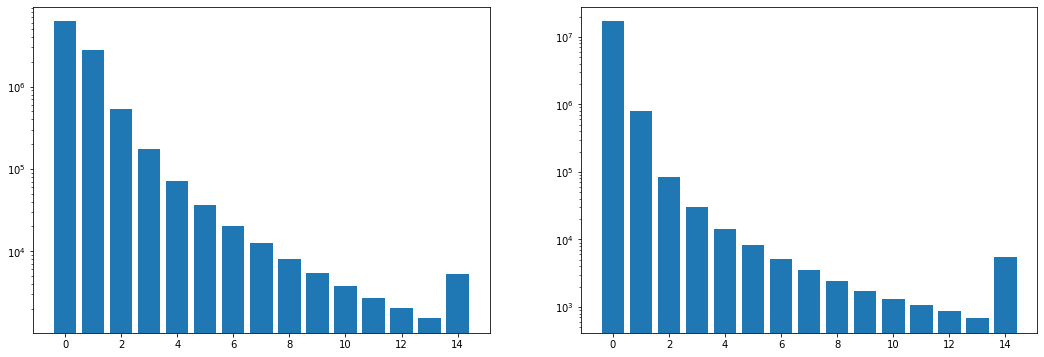

In [27]:
_, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].bar(*[t.numpy() for t in torch.unique(v0, return_counts=True)])
axs[1].bar(*[t.numpy() for t in torch.unique(v1, return_counts=True)])
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.show()

In [28]:
batch_size = 128
train_dl = torch.utils.data.DataLoader(
    PairedZeroDataset(
        pd.concat([df_matching_train, df_matching_test], axis=0)[lambda x: x['rtk'].ne('0')].values,
        data=[
            dict(chain(features_trx_train.items(), features_trx_test.items())),
            dict(chain(features_click_train.items(), features_click_test.items())),
        ],
        augmentations=[
            augmentation_chain(DropDuplicate('mcc_code', col_new_cnt='c_cnt'), RandomSlice(32, 1024)),  # 1024
            augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), RandomSlice(64, 2048)),  # 2048
        ],
        n_sample=2,
    ),
    collate_fn=PairedZeroDataset.collate_fn,
    shuffle=True,
    num_workers=24,
    batch_size=batch_size,
    persistent_workers=True,
)

valid_dl_trx = torch.utils.data.DataLoader(
    PairedDataset(
        np.sort(df_matching_valid['bank'].unique()).reshape(-1, 1), 
        data=[
            features_trx_valid,
        ],
        augmentations=[
            augmentation_chain(DropDuplicate('mcc_code', col_new_cnt='c_cnt'), SeqLenLimit(2000)),  # 2000
        ],
        n_sample=1,
    ),
    collate_fn=paired_collate_fn,
    shuffle=False,
    num_workers=4,
    batch_size=512,
    persistent_workers=True,
)

valid_dl_click = torch.utils.data.DataLoader(
    PairedDataset(
        np.sort(df_matching_valid[lambda x: x['rtk'].ne('0')]['rtk'].unique()).reshape(-1, 1),
        data=[
            features_click_valid,
        ],
        augmentations=[
            augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), SeqLenLimit(5000)),  # 5000
        ],
        n_sample=1,
    ),
    collate_fn=paired_collate_fn,
    shuffle=False,
    num_workers=4,
    batch_size=512,
    persistent_workers=True,
)

In [29]:
sup_model = PairedModule(
    ConfigFactory.parse_string('''
    common_trx_size: 256
    rnn: {
      type: gru,
      hidden_size: 256,
      bidir: false,
      trainable_starter: static
    }
    trx_seq: {
        trx_encoder: {
          use_batch_norm_with_lens: false
          norm_embeddings: false,
          embeddings_noise: 0.000,
          embeddings: {
            mcc_code: {in: 350, out: 64},
            currency_rk: {in: 10, out: 4}
            hour: {in: 30, out: 16}
            # day_diff: {in: 15, out: 8}
          },
          numeric_values: {
            transaction_amt: identity
            c_cnt: log
          }
          was_logified: false
          log_scale_factor: 1.0
        },
    }
    click_seq: {
        trx_encoder: {
          use_batch_norm_with_lens: false
          norm_embeddings: false,
          embeddings_noise: 0.000,
          embeddings: {
            cat_id: {in: 400, out: 64},
            level_0: {in: 400, out: 16}
            level_1: {in: 400, out: 8}
            level_2: {in: 400, out: 4}
            hour: {in: 30, out: 16}
            # day_diff: {in: 15, out: 8}
          },
          numeric_values: {
            c_cnt: log
          }
          was_logified: false
          log_scale_factor: 1.0
        },
    }
'''),                     
    sampling_strategy_params=ConfigFactory.parse_string('''
        train.sampling_strategy: SemiHardTriplets
        # train.balanced: true
        # train.neg_count: 10
    '''),
    loss_params=ConfigFactory.parse_string('''
        train.loss: TripletLoss
        # train.num_steps: 50
        train.margin: 0.5
    '''),
    k=100 * batch_size // 3000,
    lr=0.005, weight_decay=0,
    step_size=10 // 10, gamma=0.4 ** (1 / 10),
    base_lr=0.0005, max_lr=0.004, step_size_up=300, step_size_down=900,
)


86
109


In [30]:
class ValidationCallback(pl.Callback):
    def __init__(self, v_trx, v_click, target, device, device_main, k=100, batch_size=1024):
        self.v_trx = v_trx
        self.v_click = v_click
        self.target = target
        self.device = device
        self.device_main = device_main
        self.k = k
        self.batch_size = batch_size

    def on_train_epoch_end(self, trainer, pl_module):
        was_traning = False
        if pl_module.training:
            pl_module.eval()
            was_traning = True

        pl_module.to(self.device)
        with torch.no_grad():
            z_trx = []
            for ((x_trx, _),) in self.v_trx:
                z_trx.append(pl_module.seq_encoder_trx(x_trx.to(self.device)))
            z_trx = torch.cat(z_trx, dim=0)
            z_click = []
            for ((x_click, _),) in self.v_click:
                z_click.append(pl_module.seq_encoder_click(x_click.to(self.device)))
            z_click = torch.cat(z_click, dim=0)

            T = z_trx.size(0)
            C = z_click.size(0)
            device = z_trx.device
            ix_t = torch.arange(T, device=device).view(-1, 1).expand(T, C).flatten()
            ix_c = torch.arange(C, device=device).view(1, -1).expand(T, C).flatten()

            z_out = []
            for i in range(0, len(ix_t), self.batch_size):
                z_pairs = torch.cat([
                    z_trx[ix_t[i:i + self.batch_size]],
                    z_click[ix_c[i:i + self.batch_size]],
                ], dim=1)
                z_out.append(pl_module.cls(z_pairs).unsqueeze(1))
            z_out = torch.cat(z_out, dim=0).view(T, C)

            precision, mrr, r1 = self.logits_to_metrics(z_out)

            pl_module.log('valid_full_metrics/precision', precision, prog_bar=True)
            pl_module.log('valid_full_metrics/mrr', mrr, prog_bar=False)
            pl_module.log('valid_full_metrics/r1', r1, prog_bar=False)

        pl_module.to(self.device_main)
        if was_traning:
            pl_module.train()

    def logits_to_metrics(self, z_out):
        T, C = z_out.size()
        z_ranks = torch.zeros_like(z_out)
        z_ranks[
            torch.arange(T, device=self.device).view(-1, 1).expand(T, C),
            torch.argsort(z_out, dim=1, descending=True),
        ] = torch.arange(C, device=self.device).float().view(1, -1).expand(T, C) + 1
        z_ranks = torch.cat([
            torch.ones(T, device=self.device).float().view(-1, 1),
            z_ranks + 1,
        ], dim=1)
        
        click_uids = np.concatenate([['0'], self.v_click.dataset.pairs[:, 0]])
        true_ranks = z_ranks[
            np.arange(T),
            np.searchsorted(click_uids,
                            self.target.set_index('bank')['rtk'].loc[self.v_trx.dataset.pairs[:, 0]].values)
        ]
        precision = torch.where(true_ranks <= self.k,
                                torch.ones(1, device=self.device), torch.zeros(1, device=self.device)).mean()
        mrr = torch.where(true_ranks <= self.k, 1 / true_ranks, torch.zeros(1, device=self.device)).mean()
        r1 = 2 * mrr * precision / (mrr + precision)
        return precision, mrr, r1


In [31]:
trainer = pl.Trainer(
    gpus=[3],
    max_steps=3000,
    callbacks=[
        pl.callbacks.LearningRateMonitor(),
        pl.callbacks.ModelCheckpoint(
            every_n_train_steps=1000, save_top_k=-1,
        ),
        ValidationCallback(valid_dl_trx, valid_dl_click, df_matching_valid,
                           torch.device('cuda:2'), torch.device('cuda:3')),
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
trainer.fit(sup_model, train_dl)  # valid_dl

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type                | Params
-----------------------------------------------------------
0 | rnn_enc            | Sequential          | 395 K 
1 | _seq_encoder_trx   | Sequential          | 45.2 K
2 | _seq_encoder_click | Sequential          | 65.4 K
3 | cls                | Sequential          | 0     
4 | train_precision    | PrecisionK          | 0     
5 | train_mrr          | MeanReciprocalRankK | 0     
6 | valid_precision    | PrecisionK          | 0     
7 | valid_mrr          | MeanReciprocalRankK | 0     
-----------------------------------------------------------
505 K     Trainable params
0         Non-trainable params
505 K     Total params
2.023     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
"""
0: v1
1: v2
2: v3
3: v4
4: v5
5: v0
"""

'\n0: v1\n1: v2\n2: v3\n3: v4\n4: v\n5: v0\n'

In [35]:
df_m = get_scalars('lightning_logs/').set_index('version').loc[[f'version_{i}' for i in [1, 2, 3, 4, 5, 0]]]

# df = df_m[lambda x: x['tag'].str.startswith('train_metrics')] \
# .pivot(index='step', columns='tag', values='value')
# _, axs = plt.subplots(2, 1, figsize=(16, 15))
# for col, ax in zip(df.columns, axs):
#     df[col].plot(ax=ax, title=col, grid=True)
# plt.show()

# df = df_m[lambda x: x['tag'].str.startswith('valid_full_metrics')] \
# .pivot(index='step', columns='tag', values='value')
# _, axs = plt.subplots(3, 1, figsize=(16, 18))
# for col, ax in zip(df.columns, axs):
#     df[col].plot(ax=ax, title=col, grid=True)
# plt.show()

In [39]:
df_m[lambda x: x['tag'].str.startswith('valid_full_metrics')] \
.pivot_table(index='tag', columns='version', values='value', aggfunc=lambda x: x[-1]).round(4)

version,version_0,version_1,version_2,version_3,version_4,version_5
tag,,,,,,
valid_full_metrics/mrr,0.1935,0.1894,0.1928,0.1937,0.1908,0.1922
valid_full_metrics/precision,0.4647,0.4573,0.4580,0.4676,0.4635,0.4570
valid_full_metrics/r1,0.2733,0.2679,0.2714,0.2739,0.2703,0.2706


In [40]:
df_m[lambda x: x['tag'].str.startswith('valid_full_metrics')] \
.pivot_table(index='tag', columns='version', values='value', aggfunc=lambda x: x[-1]).mean(axis=1).round(4)

tag
valid_full_metrics/mrr          0.1921
valid_full_metrics/precision    0.4614
valid_full_metrics/r1           0.2712
dtype: float64